In [19]:
from gym.envs.classic_control import CartPoleEnv  # CartPoleEnv is a module, not an attribute -> can't indirectly import
import gym 
gym_env = gym.make("CartPole-v1")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [20]:
# dir(base_env)
# base_env.__dict__
# help(base_env)
# print(super().base_env)

In [21]:
class CartPoleWrapper(CartPoleEnv):
    """
    This wrapper changes/adds:
      - 'steps_beyond_done' now can go any number of steps beyond done (for calculating state values)
      - 'step' now returns a loss equivalent to the squared error of position
      - 'state_loss' returns the loss for the state for use in 'step'
      - 'reset' functionality to be able to set the start state by passing [x_pos, x_vel, angle, ang_vel]

      - 'get_state_2d' converts an observation into a 2D state representation, taking into account previous states
      - 'print_state_2d' shows an image of the 2D state
      - 'get_rounded_observation' bins observation so the MCTS can store it

      - 'get_action' (redundant) converts an action of 1 / 0 to a list: [0, 1] or [1, 0]
      - 'get_state_2d_size', 'get_action_size', 'get_observation', 'get_state_2d_size' are obvious
    """

    def __init__(self):
        super().__init__()
        # flattened and 2d state parameters
        self.state_bins = 60  # 30 puts us out of memory
        scaling = 1 / 3  # 1/3 gives a flat distribution if obs ~ gaussian, lowering it gives more weight to values -> 0
        # if we have linspace(0, 1, ..) then we get inf as the last two value -> they are never picked
        self.bin_edges = np.asarray(
            [norm.ppf(edge, scale=scaling) for edge in np.linspace(0.001, 0.999, num=self.state_bins)])
        self.discount = 0.5
        
        # define new actions:
        self.action_space = [-1, 0, 1]

        # to stop episodes running over
        self.steps = 0
        self.max_steps_beyond_done = 16
        self.extra_steps = 0  # counts up to max_steps once done is returned
        self.max_till_done = 200

    def step(self, action, next_true_step=False):
        assert action in self.action_space, "%r (%s) invalid" % (action, type(action))
        state = self.state
        x, x_dot, theta, theta_dot = state
        force = action*self.force_mag
        
        costheta = np.cos(theta)
        sintheta = np.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)
        done = x < -self.x_threshold \
            or x > self.x_threshold \
            or theta < -self.theta_threshold_radians \
            or theta > self.theta_threshold_radians
        done = bool(done)

        loss = self.state_loss()

        if next_true_step:
            self.steps += 1
            if done or self.steps > self.max_till_done:
                self.extra_steps += 1
                done = False
            if self.extra_steps > self.max_steps_beyond_done:
                done = True

        # if it isn't a true step then return done if fallen over
        # -> doesn't stop the sim, but does add -1 to v in MCTS
        return np.array(self.state), loss, done, {}


    def reset(self, init_state=None):
        rand_obs = super().reset()  # call the base reset to do all of the other stuff
        self.steps_beyond_done = -1  # stops an error logging if we go beyond done

        if init_state is None:
            self.steps = 0  # only want to reset steps if it is a true reset
            self.extra_steps = 0
            return rand_obs

        self.state = np.array(init_state)  # and then edit state if we want (state is a base class attribute)
        return self.state

    def get_state_2d(self, prev_state_2d=None):
        """
        curr_state numpy array [x_pos, x_vel, angle, ang_vel]
        even though it says state[3] = tip_vel in the docs, its actually ang_vel (since length = 1)
        max values are:        [+-2.4, inf, +-12 = +-0.21rad, inf]
        """
        norm_obs = self.get_rounded_observation()
        edges = np.linspace(-0.5, self.state_bins-0.5, self.state_bins+1)  # need extra to get [-0.5, ..., 24.5]
        new_pos, _, _ = np.histogram2d([norm_obs[2], ], [norm_obs[0], ], bins=(edges, edges))

        if prev_state_2d is None:
            prev_obs = (self.state[2] - self.state[3], self.state[0] - self.state[1])    # (prev_theta, prev_x)
            prev_obs = (prev_obs[0] / self.theta_threshold_radians, prev_obs[1] / self.x_threshold)

            prev_obs_binned = [np.abs(self.bin_edges - elm).argmin() for elm in prev_obs]
            prev_pos, _, _ = np.histogram2d([prev_obs_binned[0], ], [prev_obs_binned[1], ], bins=(edges, edges))
            # prev_pos[prev_pos < 1 / (2 ** 5)] = 0   # only keep up to 4 times steps back
            return new_pos + self.discount * prev_pos
        else:
            # prev_state_2d[prev_state_2d < 1 / (2 ** 5)] = 0
            return new_pos + self.discount * prev_state_2d

    def state_loss(self):
        # change the reward to -(x^2+theta^2). Technically a loss now
        done = abs(self.state[0]) > self.x_threshold or abs(self.state[2]) > self.theta_threshold_radians
        if done:
            return -1  # -1 is the maximum loss possible

        return -0.5 * ((self.state[0] / self.x_threshold) ** 2 + (self.state[2] / self.theta_threshold_radians) ** 2)

    @staticmethod
    def get_action(action):
        assert (action == 0 or action == 1)

        if action == 0:
            return np.array([1, 0])
        return np.array([0, 1])

    def get_observation(self):
        return self.state

    def get_rounded_observation(self):
        # get the values to be roughly within +-1
        obs = [self.state[0] / self.x_threshold,
               self.state[1] / self.x_threshold,
               self.state[2] / self.theta_threshold_radians,
               self.state[3] / self.theta_threshold_radians
               ]
        # get the index of teh nearest bin edge. Since bin edges near 0 are closer, weighting is better
        obs = [np.abs(self.bin_edges - elm).argmin() for elm in obs]  # should return the indexes of the norm.cdf
        return tuple(obs)

    def get_action_size(self):  # only works for discrete actions need to update!
        return len(self.action_space)

    def get_state_2d_size(self):
        return self.state_bins, self.state_bins

    def print_state_2d(self, state_2d):
        plt.imshow(state_2d, extent=[-self.x_threshold, self.x_threshold, -self.theta_threshold_radians,
                                     self.theta_threshold_radians], cmap='jet', aspect='auto')
        plt.xlabel("X-Position")
        plt.ylabel("Angular Position")
        plt.colorbar()
        plt.show()

In [22]:
env = CartPoleWrapper()   

In [27]:
# curr_state numpy array [xpos, xvel, angle, angvel]
s_obs = [-0.1, -0.1, -0.01, -0.01]
print(env.reset(s_obs))
tobs, re, d, inf = env.step(0)
print(tobs)
tobs, re, d, inf = env.step(0)
print(tobs)

[-0.1  -0.1  -0.01 -0.01]
[-0.102      -0.0998566  -0.0102     -0.01315504]
[-0.10399713 -0.09971033 -0.0104631  -0.01637319]


[-0.1  -0.1  -0.01 -0.01]
(27, 27, 26, 26)
[-0.102      -0.0998566  -0.0102     -0.01315504]


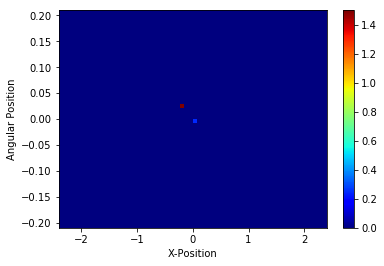

[-0.10399713 -0.09971033 -0.0104631  -0.01637319]


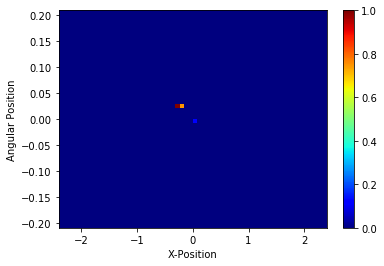

[-0.10599134  0.0955601  -0.01079056 -0.31233889]


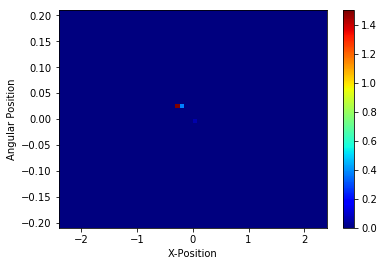

[-0.10408014  0.09571381 -0.01703734 -0.31574181]


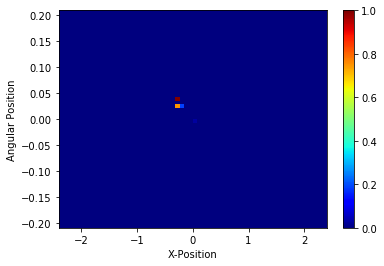

[-0.10216586  0.29107425 -0.02335218 -0.61374868]


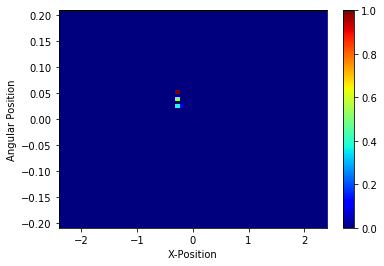

[-0.09634438  0.48651461 -0.03562715 -0.9136942 ]


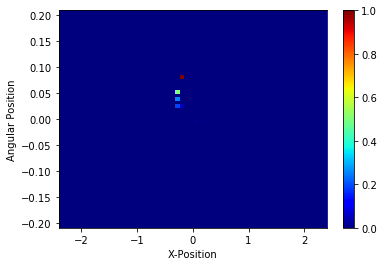

[-0.08661408  0.48699607 -0.05390104 -0.92488809]


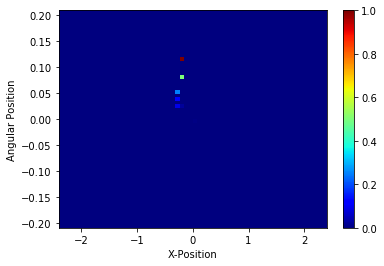

[-0.07687416  0.68280299 -0.0723988  -1.23401116]


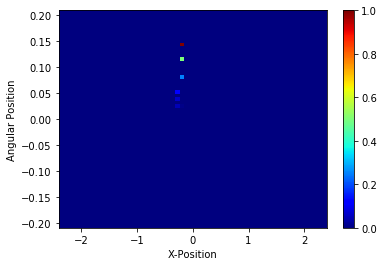

[-0.0632181   0.68372985 -0.09707902 -1.25666446]


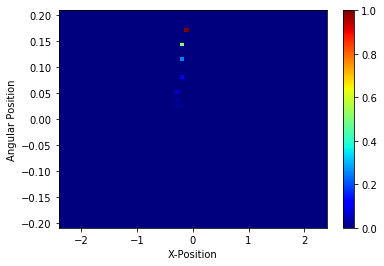

[-0.0495435   0.6849632  -0.12221231 -1.28700219]


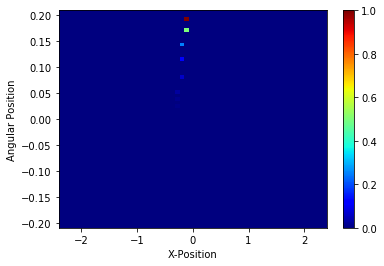

[-0.03584424  0.68649983 -0.14795235 -1.32513099]


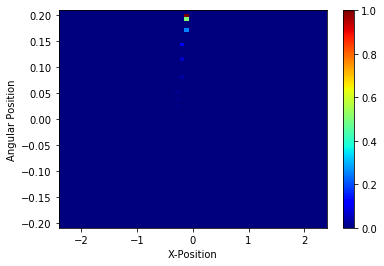

[-0.02211424  0.68833539 -0.17445497 -1.37119373]


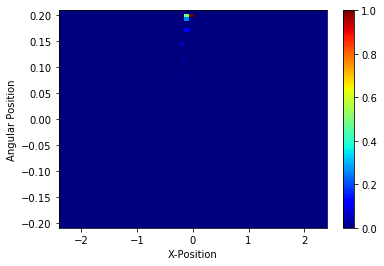

[-0.00834754  0.88515657 -0.20187885 -1.71297425]


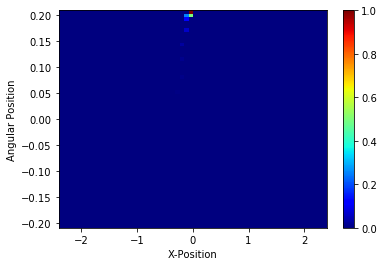

[ 0.0093556   1.08194283 -0.23613833 -2.06110906]


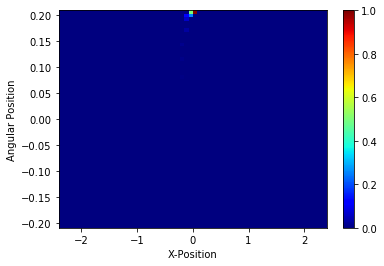

done
[ 0.0093556   1.08194283 -0.23613833 -2.06110906]
[ 0.0093556   1.08194283 -0.23613833 -2.06110906]
[ 0.0093556   1.08194283 -0.23613833 -2.06110906]
[ 0.0093556   1.08194283 -0.23613833 -2.06110906]
[ 0.0093556   1.08194283 -0.23613833 -2.06110906]
[ 0.19407432  2.05668537 -0.58818307 -4.05406116]


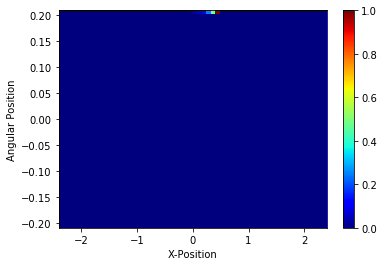

done
[ 0.19407432  2.05668537 -0.58818307 -4.05406116]
[ 0.19407432  2.05668537 -0.58818307 -4.05406116]
[ 0.19407432  2.05668537 -0.58818307 -4.05406116]
[ 0.19407432  2.05668537 -0.58818307 -4.05406116]
[ 0.19407432  2.05668537 -0.58818307 -4.05406116]
[ 0.46946044  2.56418606 -1.16297698 -5.85516532]


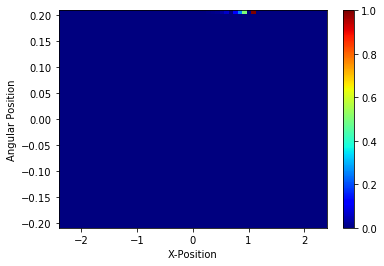

done
[ 0.46946044  2.56418606 -1.16297698 -5.85516532]
[ 0.46946044  2.56418606 -1.16297698 -5.85516532]
[ 0.46946044  2.56418606 -1.16297698 -5.85516532]
[ 0.46946044  2.56418606 -1.16297698 -5.85516532]
[ 0.46946044  2.56418606 -1.16297698 -5.85516532]
[ 0.76789051  2.52484423 -1.94719677 -7.4919415 ]


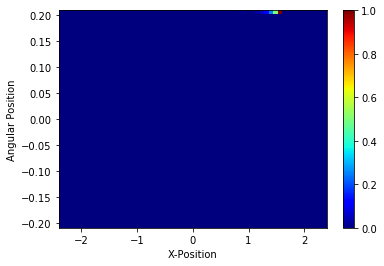

done
[ 0.76789051  2.52484423 -1.94719677 -7.4919415 ]
[ 0.76789051  2.52484423 -1.94719677 -7.4919415 ]
[ 0.76789051  2.52484423 -1.94719677 -7.4919415 ]
[ 0.76789051  2.52484423 -1.94719677 -7.4919415 ]
[ 0.76789051  2.52484423 -1.94719677 -7.4919415 ]
[ 1.10003965  3.18903117 -2.89638579 -8.0282401 ]


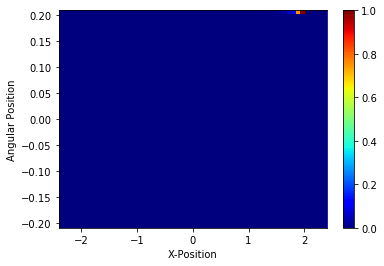

done
[ 1.10003965  3.18903117 -2.89638579 -8.0282401 ]
[ 1.10003965  3.18903117 -2.89638579 -8.0282401 ]
[ 1.10003965  3.18903117 -2.89638579 -8.0282401 ]
[ 1.10003965  3.18903117 -2.89638579 -8.0282401 ]
[ 1.10003965  3.18903117 -2.89638579 -8.0282401 ]
[ 1.51295105  3.63177306 -3.81833191 -7.13271538]


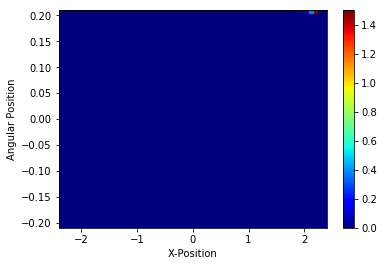

done
[ 1.51295105  3.63177306 -3.81833191 -7.13271538]
[ 1.51295105  3.63177306 -3.81833191 -7.13271538]
[ 1.51295105  3.63177306 -3.81833191 -7.13271538]
[ 1.51295105  3.63177306 -3.81833191 -7.13271538]
[ 1.51295105  3.63177306 -3.81833191 -7.13271538]
[ 1.99731533  4.39808038 -4.55825655 -4.99671955]


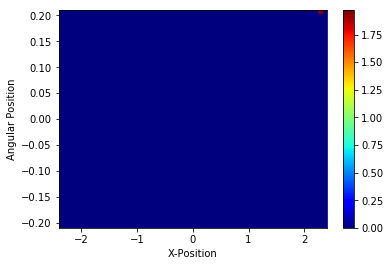

done
[ 1.99731533  4.39808038 -4.55825655 -4.99671955]
[ 1.99731533  4.39808038 -4.55825655 -4.99671955]
[ 1.99731533  4.39808038 -4.55825655 -4.99671955]
[ 1.99731533  4.39808038 -4.55825655 -4.99671955]
[ 1.99731533  4.39808038 -4.55825655 -4.99671955]
[ 2.57458643  5.21896195 -5.06692245 -3.29346639]


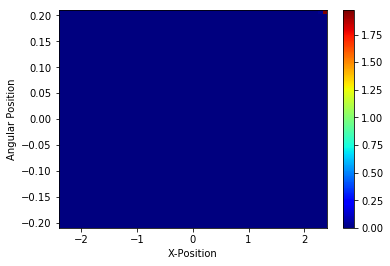

done
[ 2.57458643  5.21896195 -5.06692245 -3.29346639]
[ 2.57458643  5.21896195 -5.06692245 -3.29346639]
[ 2.57458643  5.21896195 -5.06692245 -3.29346639]
[ 2.57458643  5.21896195 -5.06692245 -3.29346639]
[ 2.57458643  5.21896195 -5.06692245 -3.29346639]
[ 3.21261472  5.40602924 -5.39049596 -1.8825256 ]


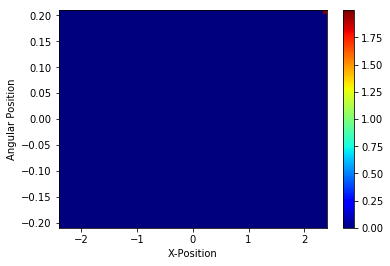

done
[ 3.21261472  5.40602924 -5.39049596 -1.8825256 ]
[ 3.21261472  5.40602924 -5.39049596 -1.8825256 ]
[ 3.21261472  5.40602924 -5.39049596 -1.8825256 ]
[ 3.21261472  5.40602924 -5.39049596 -1.8825256 ]
[ 3.21261472  5.40602924 -5.39049596 -1.8825256 ]
[ 3.88240066  5.93892205 -5.57166967 -1.1679694 ]


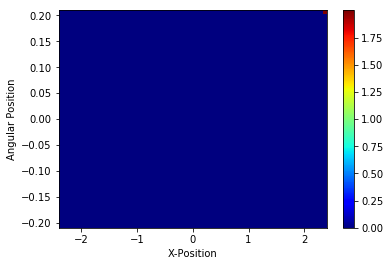

done
[ 3.88240066  5.93892205 -5.57166967 -1.1679694 ]
[ 3.88240066  5.93892205 -5.57166967 -1.1679694 ]
[ 3.88240066  5.93892205 -5.57166967 -1.1679694 ]
[ 3.88240066  5.93892205 -5.57166967 -1.1679694 ]
[ 3.88240066  5.93892205 -5.57166967 -1.1679694 ]
[ 4.63115739  6.6623361  -5.69797934 -0.95408119]


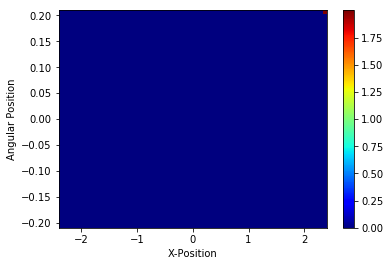

done
[ 4.63115739  6.6623361  -5.69797934 -0.95408119]
[ 4.63115739  6.6623361  -5.69797934 -0.95408119]
[ 4.63115739  6.6623361  -5.69797934 -0.95408119]
[ 4.63115739  6.6623361  -5.69797934 -0.95408119]
[ 4.63115739  6.6623361  -5.69797934 -0.95408119]
[ 5.46328202  7.39367391 -5.80703437 -0.99444732]


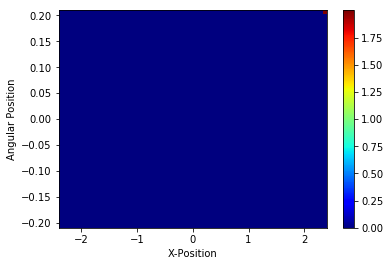

done
[ 5.46328202  7.39367391 -5.80703437 -0.99444732]
[ 5.46328202  7.39367391 -5.80703437 -0.99444732]
[ 5.46328202  7.39367391 -5.80703437 -0.99444732]
[ 5.46328202  7.39367391 -5.80703437 -0.99444732]
[ 5.46328202  7.39367391 -5.80703437 -0.99444732]
[ 6.38364004  8.13534586 -5.93285689 -1.27899947]


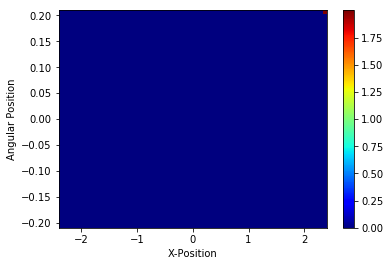

done
[ 6.38364004  8.13534586 -5.93285689 -1.27899947]
[ 6.38364004  8.13534586 -5.93285689 -1.27899947]
[ 6.38364004  8.13534586 -5.93285689 -1.27899947]
[ 6.38364004  8.13534586 -5.93285689 -1.27899947]
[ 6.38364004  8.13534586 -5.93285689 -1.27899947]
[ 7.37814178  8.5027528  -6.08495227 -1.30733418]


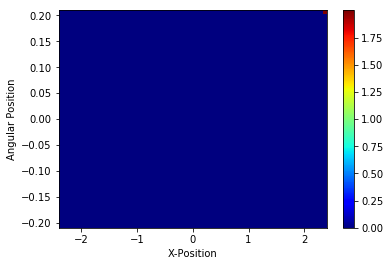

done
[ 7.37814178  8.5027528  -6.08495227 -1.30733418]
[ 7.37814178  8.5027528  -6.08495227 -1.30733418]
[ 7.37814178  8.5027528  -6.08495227 -1.30733418]
[ 7.37814178  8.5027528  -6.08495227 -1.30733418]
[ 7.37814178  8.5027528  -6.08495227 -1.30733418]
[ 8.41734766  8.88287369 -6.25548537 -1.6423795 ]


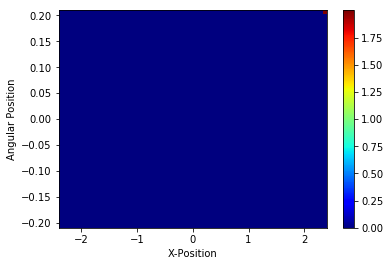

done
[ 8.41734766  8.88287369 -6.25548537 -1.6423795 ]
[ 8.41734766  8.88287369 -6.25548537 -1.6423795 ]
[ 8.41734766  8.88287369 -6.25548537 -1.6423795 ]
[ 8.41734766  8.88287369 -6.25548537 -1.6423795 ]
[ 8.41734766  8.88287369 -6.25548537 -1.6423795 ]
[ 9.50286373  9.27670712 -6.48366907 -2.34203288]


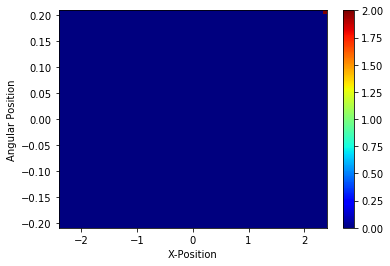

done
[ 9.50286373  9.27670712 -6.48366907 -2.34203288]
[ 9.50286373  9.27670712 -6.48366907 -2.34203288]
[ 9.50286373  9.27670712 -6.48366907 -2.34203288]
[ 9.50286373  9.27670712 -6.48366907 -2.34203288]
[ 9.50286373  9.27670712 -6.48366907 -2.34203288]
[10.64762249  9.86581334 -6.83321213 -3.74965317]


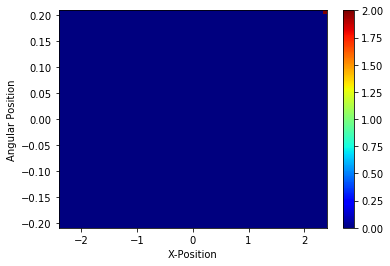

done
[10.64762249  9.86581334 -6.83321213 -3.74965317]
[10.64762249  9.86581334 -6.83321213 -3.74965317]
[10.64762249  9.86581334 -6.83321213 -3.74965317]
[10.64762249  9.86581334 -6.83321213 -3.74965317]
[10.64762249  9.86581334 -6.83321213 -3.74965317]


In [29]:
start_obs = env.reset(s_obs)
total_reward = 0.0
state2D = env.get_state_2d()
print(start_obs)
print(env.get_rounded_observation())
# env.print_state_2d(state2D)

for i in range(30):
    
    obs, reward, done, _ = env.step(gym_env.action_space.sample())
    print(obs)
    state2D = env.get_state_2d(state2D)
    # env.render()
    env.print_state_2d(state2D)

    if done:
        print("done")
        for a in range(5):
            env.step(gym_env.action_space.sample())
            print(obs)
            state2D = env.get_state_2d(state2D)
            # env.render()
            # env.print_state_2d(state2D)